In [1]:
import numpy as np
from matplotlib import pyplot as plt
from sklearn import preprocessing
import wfdb
import copy as cp
import scipy.signal as signal
import pickle
from sklearn import preprocessing
from tqdm import tqdm
import os
import re
import pandas as pd
import csv

from sklearn.linear_model import LogisticRegression
from sklearn import neighbors
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis 
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from time import time
import timeit

In [2]:
record_list = [] # Initialize the array that will hold the list of our records

records = 'mit-bih-dataframes/subject_list.csv' # Get our record list like we did in the initial extraction
with open(records) as rfile:# Load our records into the array
    for record in rfile:
        record = record[0:-1] # The -1 removes the newline ("\n") character from the string
        record_list.append(record)

In [3]:
dfdic = {}
for idx, x in enumerate(record_list):
    dfdic[x] = pd.read_csv('mit-bih-features/'+x+ '.csv', index_col=0)

In [4]:
subject_df = pd.DataFrame()
for idx, x in enumerate(record_list):
    subject_df = pd.concat([subject_df, dfdic[x]])

In [5]:
subject_df['Mappedrhythmlabels'] = subject_df['rhythmLabel'].map({'Normal':0, 'Other':0, 'AFIB':1})

In [6]:
subject_df.head()

,subsetID,rhythmLabel,StoS,StoR,StoL,RtoS,RtoR,RtoL,LtoS,LtoR,LtoL,RMS,STD,CoefVar,Range,IQR,MAD,Mappedrhythmlabels
0,04015-0.csv,Normal,0.200000,0.057143,0.028571,0.057143,0.228571,0.142857,0.057143,0.114286,0.114286,156.276998,43.660906,0.248152,155.0,78.00,32.5,0
1,04015-1.csv,Normal,0.000000,0.052632,0.000000,0.052632,0.184211,0.236842,0.000000,0.210526,0.263158,197.783973,57.233572,0.355262,213.0,93.50,55.0,0
2,04015-2.csv,Normal,0.333333,0.083333,0.055556,0.027778,0.305556,0.083333,0.111111,0.000000,0.000000,151.638551,43.820505,0.253179,138.0,72.00,56.0,0
3,04015-3.csv,Normal,0.300000,0.175000,0.000000,0.125000,0.025000,0.125000,0.075000,0.050000,0.125000,157.611865,48.827831,0.318730,167.0,79.00,59.0,0
4,04015-4.csv,Normal,0.090909,0.151515,0.090909,0.030303,0.060606,0.212121,0.212121,0.060606,0.090909,226.855681,53.260256,0.289227,237.0,95.75,66.5,0


In [7]:
statrms_dic = {
    'Accuracy': [],
    'Standard Error': [],
    'Sensitivity': [],
    'Specificity': [],
    'Precision': [],
    'F1_Score': [],
    'Run Time': []
}

indaccs = {}

In [8]:
#Logistic Regression

kf = KFold(n_splits=5, random_state=3, shuffle=True)
model = LogisticRegression(solver='liblinear')

start_time = timeit.default_timer()

acc_score = []
Truth = []
Output = []

for train_index, test_index in kf.split(subject_df): 
    
    X_train = subject_df.iloc[train_index, 11].values.reshape(-1,1)
    X_test = subject_df.iloc[test_index, 11].values.reshape(-1,1)
    Y_train = subject_df.iloc[train_index, -1]
    Y_test = subject_df.iloc[test_index, -1]

    model.fit(X_train, Y_train)
    pred_values = model.predict(X_test)

    acc = accuracy_score(Y_test, pred_values)
    acc_score.append(acc)

    Truth.extend(Y_test.values.reshape(Y_test.shape[0])) 
    Output.extend(pred_values)

elapsed = timeit.default_timer() - start_time



print("---Run time is %s seconds ---" % elapsed)
print()
print('Accuracy of each fold: \n {}'.format(acc_score))
print("Avg accuracy: {}".format(np.mean(acc_score)))
print('Std of accuracy : \n{}'.format(np.std(acc_score)))
print()
print(confusion_matrix(Truth, Output))
print()
print(classification_report(Truth, Output))

cm = confusion_matrix(Truth, Output)

sensitivity = cm[0][0]/(cm[0][0]+cm[0][1])
specificity = cm[1][1]/(cm[1][0]+cm[1][1])
precision = (cm[0][0])/(cm[0][0]+cm[1][0])
f1_score = (2*precision*sensitivity)/(precision+sensitivity)

print(sensitivity)
print(specificity)
print(precision)
print(f1_score)

statrms_dic["Run Time"].append(elapsed)
statrms_dic['Accuracy'].append(np.mean(acc_score))
statrms_dic['Standard Error'].append(np.std(acc_score))
statrms_dic['Sensitivity'].append(sensitivity)
statrms_dic['Specificity'].append(specificity)
statrms_dic['Precision'].append(precision)
statrms_dic['F1_Score'].append(f1_score)

indaccs['LogReg'] = acc_score

---Run time is 0.2429232609999996 seconds ---

Accuracy of each fold: 
 [0.8362347866276383, 0.8281972265023112, 0.8354391371340524, 0.8440677966101695, 0.8454545454545455]
Avg accuracy: 0.8378786984657435
Std of accuracy : 
0.006294175060170281

[[16666  2760]
 [ 2501 10524]]

              precision    recall  f1-score   support

           0       0.87      0.86      0.86     19426
           1       0.79      0.81      0.80     13025

    accuracy                           0.84     32451
   macro avg       0.83      0.83      0.83     32451
weighted avg       0.84      0.84      0.84     32451

0.8579223720786575
0.8079846449136276
0.8695153127771691
0.8636799419583863


In [9]:
#LDA
kf = KFold(n_splits=5, random_state=3, shuffle=True)
model=LinearDiscriminantAnalysis()

start_time = timeit.default_timer()

acc_score = []
Truth = []
Output = []

for train_index, test_index in kf.split(subject_df):
    X_train = subject_df.iloc[train_index, 11].values.reshape(-1,1)
    X_test = subject_df.iloc[test_index, 11].values.reshape(-1,1)
    Y_train = subject_df.iloc[train_index, -1]
    Y_test = subject_df.iloc[test_index, -1]

    model.fit(X_train, Y_train)
    pred_values = model.predict(X_test)
    

    acc = accuracy_score(Y_test, pred_values)
    acc_score.append(acc)

    Truth.extend(Y_test.values.reshape(Y_test.shape[0])) 
    Output.extend(pred_values)

elapsed = timeit.default_timer() - start_time



print("---Run time is %s seconds ---" % elapsed)
print()
print('Accuracy of each fold: \n {}'.format(acc_score))
print("Avg accuracy: {}".format(np.mean(acc_score)))
print('Std of accuracy : \n{}'.format(np.std(acc_score)))
print()
print(confusion_matrix(Truth, Output))
print()
print(classification_report(Truth, Output))

cm = confusion_matrix(Truth, Output)

sensitivity = cm[0][0]/(cm[0][0]+cm[0][1])
specificity = cm[1][1]/(cm[1][0]+cm[1][1])
precision = (cm[0][0])/(cm[0][0]+cm[1][0])
f1_score = (2*precision*sensitivity)/(precision+sensitivity)

print(sensitivity)
print(specificity)
print(precision)
print(f1_score)

statrms_dic["Run Time"].append(elapsed)
statrms_dic['Accuracy'].append(np.mean(acc_score))
statrms_dic['Standard Error'].append(np.std(acc_score))
statrms_dic['Sensitivity'].append(sensitivity)
statrms_dic['Specificity'].append(specificity)
statrms_dic['Precision'].append(precision)
statrms_dic['F1_Score'].append(f1_score)

indaccs['LDA'] = acc_score

---Run time is 0.13058033499999944 seconds ---

Accuracy of each fold: 
 [0.8362347866276383, 0.8288135593220339, 0.8355932203389831, 0.8440677966101695, 0.8451463790446841]
Avg accuracy: 0.8379711483887018
Std of accuracy : 
0.0060197007565451575

[[16621  2805]
 [ 2453 10572]]

              precision    recall  f1-score   support

           0       0.87      0.86      0.86     19426
           1       0.79      0.81      0.80     13025

    accuracy                           0.84     32451
   macro avg       0.83      0.83      0.83     32451
weighted avg       0.84      0.84      0.84     32451

0.8556058890147226
0.8116698656429943
0.8713956170703575
0.8634285714285713


In [10]:
#QDA
kf = KFold(n_splits=5, random_state=3, shuffle=True)
model=QuadraticDiscriminantAnalysis()

start_time = timeit.default_timer()

acc_score = []
Truth = []
Output = []

for train_index, test_index in kf.split(subject_df):
    
    X_train = subject_df.iloc[train_index, 11].values.reshape(-1,1)
    X_test = subject_df.iloc[test_index, 11].values.reshape(-1,1)
    Y_train = subject_df.iloc[train_index, -1]
    Y_test = subject_df.iloc[test_index, -1]

    model.fit(X_train, Y_train)
    pred_values = model.predict(X_test)
    

    acc = accuracy_score(Y_test, pred_values)
    acc_score.append(acc)

    Truth.extend(Y_test.values.reshape(Y_test.shape[0])) 
    Output.extend(pred_values)

elapsed = timeit.default_timer() - start_time



print("---Run time is %s seconds ---" % elapsed)
print()
print('Accuracy of each fold: \n {}'.format(acc_score))
print("Avg accuracy: {}".format(np.mean(acc_score)))
print('Std of accuracy : \n{}'.format(np.std(acc_score)))
print()
print(confusion_matrix(Truth, Output))
print()
print(classification_report(Truth, Output))

cm = confusion_matrix(Truth, Output)

sensitivity = cm[0][0]/(cm[0][0]+cm[0][1])
specificity = cm[1][1]/(cm[1][0]+cm[1][1])
precision = (cm[0][0])/(cm[0][0]+cm[1][0])
f1_score = (2*precision*sensitivity)/(precision+sensitivity)

print(sensitivity)
print(specificity)
print(precision)
print(f1_score)

statrms_dic["Run Time"].append(elapsed)
statrms_dic['Accuracy'].append(np.mean(acc_score))
statrms_dic['Standard Error'].append(np.std(acc_score))
statrms_dic['Sensitivity'].append(sensitivity)
statrms_dic['Specificity'].append(specificity)
statrms_dic['Precision'].append(precision)
statrms_dic['F1_Score'].append(f1_score)

indaccs['QDA'] = acc_score

---Run time is 0.22255140399999895 seconds ---

Accuracy of each fold: 
 [0.8380835002310892, 0.8303543913713405, 0.8392912172573189, 0.8468412942989214, 0.8486902927580894]
Avg accuracy: 0.8406521391833518
Std of accuracy : 
0.00659410613337804

[[16554  2872]
 [ 2299 10726]]

              precision    recall  f1-score   support

           0       0.88      0.85      0.86     19426
           1       0.79      0.82      0.81     13025

    accuracy                           0.84     32451
   macro avg       0.83      0.84      0.84     32451
weighted avg       0.84      0.84      0.84     32451

0.8521569031195305
0.8234932821497121
0.8780565427252958
0.8649128765119256


In [11]:
#KNN-CV
KNN_result = []
X=subject_df["RMS"].values.reshape(-1,1)
Y=subject_df["Mappedrhythmlabels"]
crossvalidation = KFold(n_splits=5, random_state=3, shuffle=True)
KNNResult = []
for k in range(1,31):
    knn = neighbors.KNeighborsClassifier(n_neighbors=k)
    model = knn.fit(X, Y)
    scores=cross_val_score(model, X, Y, cv=crossvalidation)
    print('K = {}'.format(k))
    print('Accuracy of each fold: \n {}'.format(scores))
    print("Avg accuracy: {}".format(scores.mean()))
    print()
    KNN_result.append(scores.mean())
print(np.max(KNN_result))

K = 1
Accuracy of each fold: 
 [0.78123556 0.77765794 0.78181818 0.78936826 0.79322034]
Avg accuracy: 0.7846600543742087

K = 2
Accuracy of each fold: 
 [0.76120783 0.75577812 0.76009245 0.76795069 0.76086287]
Avg accuracy: 0.7611783911301628

K = 3
Accuracy of each fold: 
 [0.80835002 0.80323575 0.81217257 0.81864407 0.8238829 ]
Avg accuracy: 0.8132570616325697

K = 4
Accuracy of each fold: 
 [0.80187953 0.78844376 0.801849   0.80508475 0.81201849]
Avg accuracy: 0.8018551038667028

K = 5
Accuracy of each fold: 
 [0.82267755 0.81309707 0.82434515 0.83035439 0.83436055]
Avg accuracy: 0.8249669436809388

K = 6
Accuracy of each fold: 
 [0.8209829  0.80939908 0.82280431 0.82434515 0.82511556]
Avg accuracy: 0.8205293996024837

K = 7
Accuracy of each fold: 
 [0.8274534  0.81694915 0.82881356 0.83805855 0.84067797]
Avg accuracy: 0.8303905253190443

K = 8
Accuracy of each fold: 
 [0.82760746 0.81448382 0.82896764 0.8375963  0.8348228 ]
Avg accuracy: 0.8286956053172118

K = 9
Accuracy of each f

In [12]:
#KNN-CV
kf = KFold(n_splits=5, random_state=3, shuffle=True)
model=neighbors.KNeighborsClassifier(n_neighbors=7)

start_time = timeit.default_timer()

acc_score = []
Truth = []
Output = []

for train_index, test_index in kf.split(subject_df): 
    
    X_train = subject_df.iloc[train_index, 11].values.reshape(-1,1)
    X_test = subject_df.iloc[test_index, 11].values.reshape(-1,1)
    Y_train = subject_df.iloc[train_index, -1]
    Y_test = subject_df.iloc[test_index, -1]

    model.fit(X_train, Y_train)
    pred_values = model.predict(X_test)

    acc = accuracy_score(Y_test, pred_values)
    acc_score.append(acc)

    Truth.extend(Y_test.values.reshape(Y_test.shape[0])) 
    Output.extend(pred_values)

elapsed = timeit.default_timer() - start_time

print()


print("---Run time is %s seconds ---" % elapsed)
print()
print('Accuracy of each fold: \n {}'.format(acc_score))
print("Avg accuracy: {}".format(np.mean(acc_score)))
print('Std of accuracy : \n{}'.format(np.std(acc_score)))
print()
print(confusion_matrix(Truth, Output))
print()
print(classification_report(Truth, Output))

cm = confusion_matrix(Truth, Output)

sensitivity = cm[0][0]/(cm[0][0]+cm[0][1])
specificity = cm[1][1]/(cm[1][0]+cm[1][1])
precision = (cm[0][0])/(cm[0][0]+cm[1][0])
f1_score = (2*precision*sensitivity)/(precision+sensitivity)

print(sensitivity)
print(specificity)
print(precision)
print(f1_score)

statrms_dic["Run Time"].append(elapsed)
statrms_dic['Accuracy'].append(np.mean(acc_score))
statrms_dic['Standard Error'].append(np.std(acc_score))
statrms_dic['Sensitivity'].append(sensitivity)
statrms_dic['Specificity'].append(specificity)
statrms_dic['Precision'].append(precision)
statrms_dic['F1_Score'].append(f1_score)

indaccs['KNN-CV'] = acc_score


---Run time is 2.8991840249999967 seconds ---

Accuracy of each fold: 
 [0.8274533970112463, 0.8169491525423729, 0.8288135593220339, 0.8380585516178737, 0.8406779661016949]
Avg accuracy: 0.8303905253190443
Std of accuracy : 
0.008442915512424841

[[15945  3481]
 [ 2023 11002]]

              precision    recall  f1-score   support

           0       0.89      0.82      0.85     19426
           1       0.76      0.84      0.80     13025

    accuracy                           0.83     32451
   macro avg       0.82      0.83      0.83     32451
weighted avg       0.84      0.83      0.83     32451

0.8208071656542778
0.8446833013435701
0.8874109528049866
0.8528106113280206


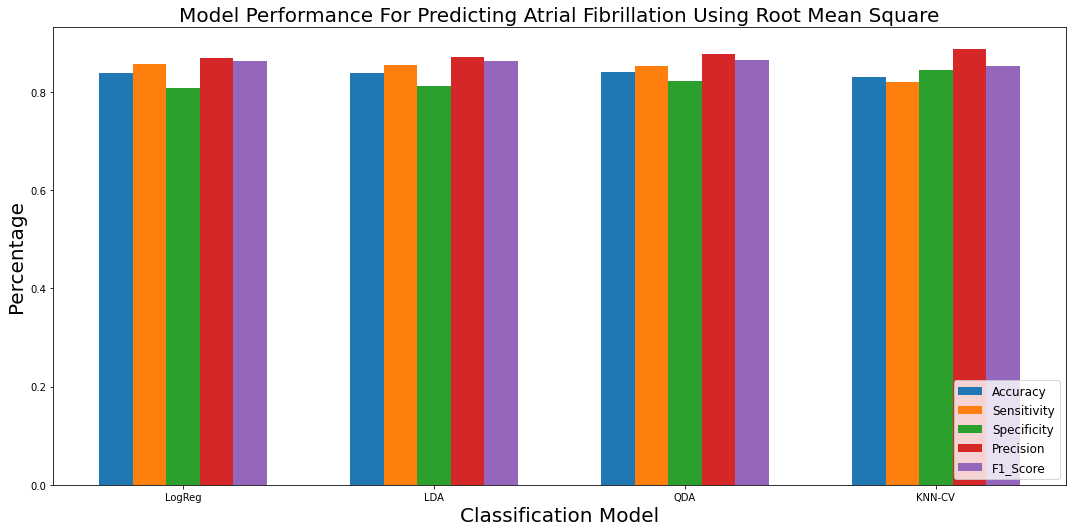

In [13]:
models = ['LogReg', 'LDA', 'QDA', 'KNN-CV']
accuracies = statrms_dic["Accuracy"]
sensitivities = statrms_dic["Sensitivity"]
specificities = statrms_dic["Specificity"]
precisions = statrms_dic["Precision"]
f1_scores = statrms_dic["F1_Score"]



x = 6*np.arange(len(models))
width = 0.8

fig, ax = plt.subplots(figsize=(15, 7.5))
acc = ax.bar(x-width*2, accuracies, width, label='Accuracy')
sen = ax.bar(x-width, sensitivities, width, label='Sensitivity')
spe = ax.bar(x,specificities, width, label='Specificity')
pre = ax.bar(x+width, precisions, width, label='Precision')
f1 = ax.bar(x+width*2 , f1_scores, width, label='F1_Score')

ax.set_xlabel('Classification Model', fontsize=20)
ax.set_ylabel('Percentage', fontsize=20)
ax.set_title('Model Performance For Predicting Atrial Fibrillation Using Root Mean Square', fontsize=20)
ax.set_xticks(x)
ax.set_xticklabels(models)
ax.legend()


fig.tight_layout()

plt.legend(loc="lower right", prop={'size': 12})
plt.show()

fig.savefig('RmsModel.png')

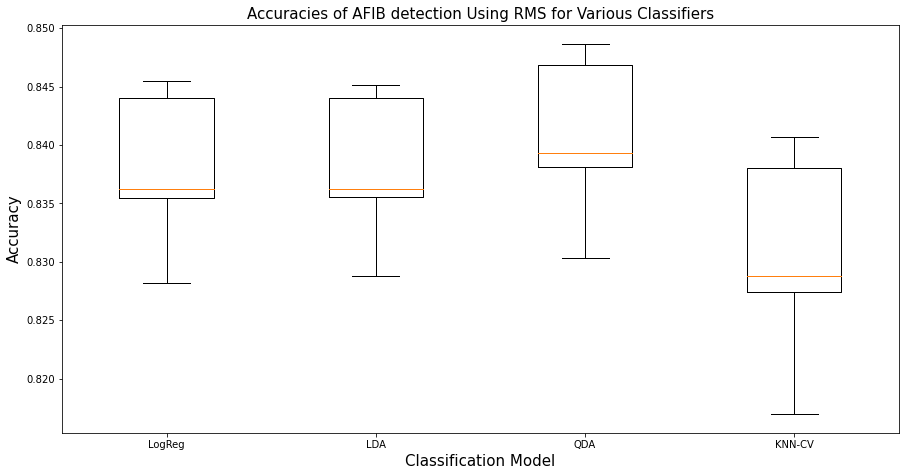

In [14]:
#Box Plots

models = ['LogReg', 'LDA', 'QDA', 'KNN-CV']

x = np.arange(len(models))+1

LogRegAcc = indaccs['LogReg']
LDAAcc = indaccs['LDA']
QDAAcc = indaccs['QDA']
KNNAcc = indaccs['KNN-CV']

data = [LogRegAcc, LDAAcc, QDAAcc, KNNAcc]

fig, ax = plt.subplots(figsize = (15,7.5))
ax.boxplot(data)

ax.set_title('Accuracies of AFIB detection Using RMS for Various Classifiers', fontsize=15)
ax.set_xlabel('Classification Model', fontsize=15)
ax.set_ylabel('Accuracy', fontsize=15)
ax.set_xticks(x)
ax.set_xticklabels(models)

plt.show()

fig.savefig('RmsBox.png')

In [15]:
rmsdf = pd.DataFrame(
    data = np.transpose(np.array([
                                statrms_dic["Accuracy"],
                                statrms_dic["Standard Error"],
                                statrms_dic["Sensitivity"],
                                statrms_dic["Specificity"],
                                statrms_dic["Precision"],
                                statrms_dic["F1_Score"],
                                statrms_dic["Run Time"] 
                            ])
                       ),
    
    columns = ["Accuracy", "Standard Error", "Sensitivity", "Specificity", "Precision", "F1-Score", "Run Time"]
    
)

rmsdf.set_index(pd.Index(["LogReg", "LDA", "QDA", "KNN-CV"]))

,Accuracy,Standard Error,Sensitivity,Specificity,Precision,F1-Score,Run Time
LogReg,0.837879,0.006294,0.857922,0.807985,0.869515,0.863680,0.242923
LDA,0.837971,0.006020,0.855606,0.811670,0.871396,0.863429,0.130580
QDA,0.840652,0.006594,0.852157,0.823493,0.878057,0.864913,0.222551
KNN-CV,0.830391,0.008443,0.820807,0.844683,0.887411,0.852811,2.899184
